In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

from npiv import iv_simulator
from npiv import custom_objectives

In [2]:
# 0. random data.  price is endogenous, instrument is this 
n = 100000 # number of observations
d = 2 # dimensionality of the exogenous regressors in x
    
ivsim = iv_simulator.IVSimulator(num_exog_x_cols=d)
df = ivsim.generate_data(num_obs=n)
df['id'] = np.arange(n)

In [3]:
print(ivsim.exog_x_cols, ivsim.endog_x_col, ivsim.instrument_col, ivsim.y_col)
display(ivsim.log_cost_coefs)
display(ivsim.log_sales_coefs)
display(df.describe())

['x_0', 'x_1'] log_price instrument log_sales


x_0    0.707107
x_1    0.707107
dtype: float64

x_0          0.707107
x_1          0.707107
log_price   -4.000000
dtype: float64

,x_0,x_1,unobserved_elast,unobserved_log_cost,unobserved_log_optimal_price,instrument,log_price,log_sales,id
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-0.001323,-0.002421,-4.004591,-0.002648,0.406705,0.000064,0.406769,-1.211168,49999.500000
std,0.999793,1.001009,1.616034,0.998919,1.047431,0.057836,1.049555,3.569429,28867.657797
min,-4.093153,-4.399192,-6.799973,-4.277556,-3.989070,-0.099999,-4.049079,-23.336295,0.000000
25%,-0.676622,-0.677018,-5.402489,-0.678321,-0.302696,-0.050255,-0.304784,-3.081064,24999.750000
50%,-0.000108,-0.001623,-4.011444,-0.004192,0.396358,-0.000090,0.396826,-1.315862,49999.500000
75%,0.674169,0.674212,-2.601434,0.676775,1.111094,0.050353,1.113218,0.636327,74999.250000
max,4.458872,4.173449,-1.200075,4.618235,5.364919,0.099998,5.379462,22.936517,99999.000000


[0.2, 0.5, 0.8, 0.9, 0.95, 0.99]


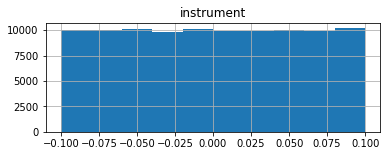

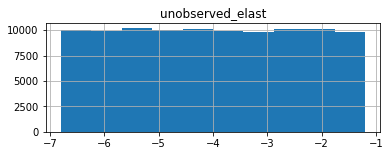

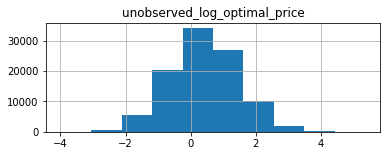

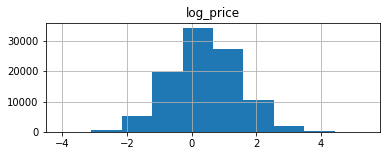

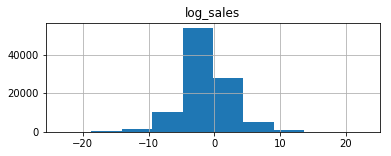

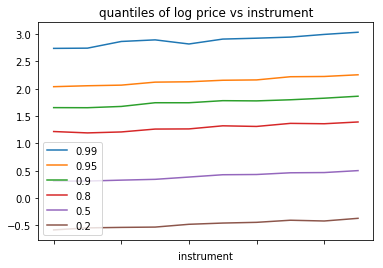

In [4]:
# 1. Look at this data
df.hist('instrument', figsize=(6,2))
df.hist('unobserved_elast', figsize=(6,2))
df.hist('unobserved_log_optimal_price', figsize=(6,2))
df.hist('log_price', figsize=(6,2))
df.hist('log_sales', figsize=(6,2))
quantiles = [.2, .5, .8, .9, .95, .99]
print(quantiles)
qtl_df = df.groupby(pd.qcut(df['instrument'], 10))['log_price'].quantile(list(reversed(quantiles)))
qtl_df.unstack(level=1).plot(legend=True, title = "quantiles of log price vs instrument")
plt.legend()

In [5]:
# 2. do naive regression of y vs exogenous x + price
tmp_xcols = ivsim.exog_x_cols+[ivsim.endog_x_col]
lm = LinearRegression()
lm.fit(df[tmp_xcols], df[ivsim.y_col])
naive_coefs = pd.DataFrame.from_dict(dict(zip(tmp_xcols, lm.coef_)),orient='index', columns=["naive_coefs"])
display(naive_coefs)
print('intercept', lm.intercept_)
# coef on log price is much less negative than truth

,naive_coefs
x_0,-1.620738
x_1,-1.624398
log_price,-0.711594


intercept -0.927791062515


In [6]:
# 3. the reduced form.  just do a linear reg for now
tmp_xcols = ivsim.exog_x_cols+[ivsim.instrument_col]
stage1_model = LinearRegression()
stage1_model.fit(df[tmp_xcols], df[ivsim.y_col])
stage1_coefs = pd.DataFrame.from_dict(dict(zip(tmp_xcols, stage1_model.coef_)),orient='index', columns=["naive_coefs"])
display(stage1_coefs)
print("intercept:", stage1_model.intercept_)
# here, the coef on the instrument is just the true coef.
#  the impact of the price correlation with elasticity is captured purely as a bias term in the intercept

,naive_coefs
x_0,-2.123544
x_1,-2.127468
instrument,-3.861599


intercept: -1.21888356416


In [7]:
# 4. now compute some quantiles
log_price_qtl_cols = []
interval = .05
qtls = np.arange(0,1,interval) + interval/2
print("computing these conditional quantiles of log price: {}".format(qtls))
for qtl in qtls:
    qcol = 'log_price_qtl_{:.2f}'.format(qtl)
    df[qcol] = ivsim.compute_log_price_quantile_given_cost_and_instrument(df['unobserved_log_cost'], df['instrument'], qtl)
    log_price_qtl_cols.append(qcol)
print("these are the relevant columns: {}".format(log_price_qtl_cols))

computing these conditional quantiles of log price: [ 0.025  0.075  0.125  0.175  0.225  0.275  0.325  0.375  0.425  0.475
  0.525  0.575  0.625  0.675  0.725  0.775  0.825  0.875  0.925  0.975]
these are the relevant columns: ['log_price_qtl_0.03', 'log_price_qtl_0.08', 'log_price_qtl_0.12', 'log_price_qtl_0.18', 'log_price_qtl_0.23', 'log_price_qtl_0.28', 'log_price_qtl_0.33', 'log_price_qtl_0.38', 'log_price_qtl_0.43', 'log_price_qtl_0.48', 'log_price_qtl_0.53', 'log_price_qtl_0.58', 'log_price_qtl_0.63', 'log_price_qtl_0.68', 'log_price_qtl_0.73', 'log_price_qtl_0.78', 'log_price_qtl_0.83', 'log_price_qtl_0.88', 'log_price_qtl_0.93', 'log_price_qtl_0.98']


In [8]:
# 5. construct data for doing deepiv with these true quantiles
#    this will involve just duplicating the data a bunch of times,
#    each time for each quantile of log price
dfs_to_concat = []
for c in log_price_qtl_cols:
    tmp_df = df[['id']+ivsim.exog_x_cols+[c]+[ivsim.y_col]].rename(columns={c:'log_price_synthetic'})
    dfs_to_concat.append(tmp_df)
df_synthetic = pd.concat(dfs_to_concat)

In [9]:
# 6. do deepiv with the upper bound loss with true quantiles
lm = LinearRegression()
tmp_x_cols = ivsim.exog_x_cols+['log_price_synthetic']
lm.fit(df_synthetic[tmp_x_cols], df_synthetic[ivsim.y_col])
print(lm.intercept_, lm.coef_)
print(ivsim.log_sales_coefs)

-1.16347945574 [-2.02845848 -2.03225368 -0.13627882]
x_0          0.707107
x_1          0.707107
log_price   -4.000000
dtype: float64


In [10]:
# 7. that doesn't look so good.
#  what if we just use a single quantile (the median) instead of many?
lm = LinearRegression()
tmp_df = df.copy()
tmp_df['log_price_synthetic'] = ivsim.compute_log_price_quantile_given_cost_and_instrument(df['unobserved_log_cost'], 
                                                                                           df['instrument'], .5)
tmp_x_cols = ivsim.exog_x_cols+['log_price_synthetic']
lm.fit(tmp_df[tmp_x_cols], tmp_df[ivsim.y_col])
print(lm.intercept_, lm.coef_)
print(ivsim.log_sales_coefs)
# coef on price is actually close to what we expect now (-4)
# i think the issue with the above is EIV, since price 

-0.107970653221 [ 0.60701914  0.60309518 -3.86159937]
x_0          0.707107
x_1          0.707107
log_price   -4.000000
dtype: float64


In [15]:
# 8. ok, now let's try the real objective instead of this upper-bounded version
#    in order to do so we need to compute a per-id loss function rather than 
#    entry-by-entry in this expanded dataframe.  basically, for each id, we want
#    the mean of the coefs*features to be close to y
#    such that the per-id sum of these (a*xhat+b) is close to y
# def loss_func(coefs, dfhat, x_cols, y_col, grouping_col):
#     intercept, actual_coefs = coefs[0], coefs[1:]
#     tmp_df = dfhat[[y_col, grouping_col]].copy()
#     tmp_df['yhat'] = intercept + (dfhat[x_cols].multiply(actual_coefs)).sum(axis=1)
#     agg_df = tmp_df.groupby(grouping_col)[[y_col, 'yhat']].mean()
#     loss = ((agg_df[y_col]-agg_df['yhat'])**2).sum()
#     return loss
loss_func = custom_objectives.grouped_sse_loss_linear
# try out this loss for some random coefs.  loss should be decreasing as we appraoch truth
tmp_xcols = ivsim.exog_x_cols+['log_price_synthetic']
print(loss_func([0,0,0,0],    df_synthetic, x_cols=tmp_xcols, y_col=ivsim.y_col, grp_col='id'))
print(loss_func([0,1,1,-2],   df_synthetic, x_cols=tmp_xcols, y_col=ivsim.y_col, grp_col='id'))
print(loss_func([0,.7,.7,-2], df_synthetic, x_cols=tmp_xcols, y_col=ivsim.y_col, grp_col='id'))
print(loss_func([0,.7,.7,-4], df_synthetic, x_cols=tmp_xcols, y_col=ivsim.y_col, grp_col='id'))
print(loss_func([.4,.7,.7,-4], df_synthetic, x_cols=tmp_xcols, y_col=ivsim.y_col, grp_col='id'),
        "this should be the best")
print(loss_func([.4,.7,.7,-6], df_synthetic, x_cols=tmp_xcols, y_col=ivsim.y_col, grp_col='id'))
print(loss_func([0  ,.7,.7,-6], df_synthetic, x_cols=tmp_xcols, y_col=ivsim.y_col, grp_col='id'))
# ok, so the true parameters (.4, .7, .7, .-4) seem to do best out of the few i've tried, so is ok

568304939.542
387241831.707
312468964.656
153439666.796
146579079.482
334931339.863
367758969.772


In [16]:
# now actually optimize it. takes maybe a minute to finish?
min_output = minimize(fun = custom_objectives.grouped_sse_loss_linear, 
                      x0=np.zeros(shape=len(tmp_xcols)+1), 
                      args = (df_synthetic, tmp_xcols, ivsim.y_col, 'id'))
min_output
# appears to work pretty well, in that the true coefs are not that far off from what they should be.

      fun: 146567218.95271155
 hess_inv: array([[  9.68484173e-09,   5.62686442e-09,   1.10361001e-08,
         -1.33765490e-08],
       [  5.62686441e-09,   3.50936392e-08,   2.59749997e-08,
         -3.41989369e-08],
       [  1.10361001e-08,   2.59749997e-08,   4.53130905e-08,
         -4.60332158e-08],
       [ -1.33765490e-08,  -3.41989369e-08,  -4.60332158e-08,
          5.66363015e-08]])
      jac: array([ 4.,  2.,  4.,  4.])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 456
      nit: 10
     njev: 74
   status: 2
  success: False
        x: array([ 0.35788149,  0.60701875,  0.60309478, -3.8615988 ])

In [32]:
a

array([0, 1, 2, 9, 4])

In [36]:
np.arange()

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [18]:
# 9. ok, this has all been assuming we know the quantiles.  let's try something 
#    simple wehre we actually estimate the first stage: 2sls
# first stage
lm_stage1 = LinearRegression()
x_cols_stage1 = ivsim.exog_x_cols + [ivsim.instrument_col]
y_col_stage1 = 'log_price'
lm_stage1.fit(df[x_cols_stage1], df[y_col_stage1])
print(lm_stage1.intercept_, lm_stage1.coef_)
# now, second stage
df['log_price_hat_2sls'] = lm_stage1.predict(df[x_cols_stage1])
lm_stage2 = LinearRegression()
x_cols_stage2 = ivsim.exog_x_cols + ['log_price_hat_2sls']
y_col_stage2 = ivsim.y_col
lm_stage2.fit(df[x_cols_stage2], df[y_col_stage2])
print(lm_stage2.intercept_, lm_stage2.coef_, "these should resemble the truth")
# looks good

0.409355560914 [ 0.70809925  0.70831887  1.02794063]
0.318916510702 [ 0.53652758  0.53342866 -3.75663658] these should resemble the truth
